# **Data Preparation Notebook - NYC Collisions Tabular**

## **Initial Steps**

### Import the required libraries

In [44]:
import os
import pandas as pd
from pandas import concat, DataFrame, Series
from matplotlib.pyplot import show, figure, savefig, subplots
from utils.ds_charts import bar_chart, get_variable_types, multiple_bar_chart
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from numpy import nan

DATA_FOLDER = "data/"
DATA_PREP_FOLDER = DATA_FOLDER + "data-prep/"
DATA_FILE = DATA_FOLDER + "original_tabular.csv"
IMAGES_FOLDER = "images/"
DIMENSIONALITY_FOLDER = IMAGES_FOLDER + "missing-values/"
SCALING_FOLDER = IMAGES_FOLDER + "scaling/"
BALANCING_FOLDER = IMAGES_FOLDER + "balancing/"

if not os.path.exists(DATA_PREP_FOLDER):
    os.makedirs(DATA_PREP_FOLDER)

if not os.path.exists(DIMENSIONALITY_FOLDER):
    os.makedirs(DIMENSIONALITY_FOLDER)
    
if not os.path.exists(SCALING_FOLDER):
    os.makedirs(SCALING_FOLDER)
    
if not os.path.exists(BALANCING_FOLDER):
    os.makedirs(BALANCING_FOLDER)

df = pd.read_csv(DATA_FILE, parse_dates=[["CRASH_DATE", "CRASH_TIME"]])
df.rename(columns={'CRASH_DATE_CRASH_TIME': 'CRASH_DATETIME'}, inplace=True)

### Remove unnecessary ID columns

In [45]:
df.drop(['VEHICLE_ID','PERSON_ID','UNIQUE_ID','COLLISION_ID'], axis=1, inplace=True)

# The emotional status column doesn't give us any new information, since when a person is killed in an accident, it'll be inconcious
df.drop(['EMOTIONAL_STATUS'], axis=1, inplace=True)

df

,CRASH_DATETIME,PERSON_AGE,BODILY_INJURY,SAFETY_EQUIPMENT,PERSON_SEX,PERSON_TYPE,PED_LOCATION,CONTRIBUTING_FACTOR_2,EJECTION,COMPLAINT,CONTRIBUTING_FACTOR_1,POSITION_IN_VEHICLE,PED_ROLE,PED_ACTION,PERSON_INJURY
0,2021-01-01 00:00:00,37.0,Neck,Lap Belt & Harness,M,Occupant,NaN,NaN,Not Ejected,Complaint of Pain or Nausea,NaN,Driver,Driver,NaN,Injured
1,2021-01-01 00:00:00,22.0,Shoulder - Upper Arm,Lap Belt & Harness,M,Occupant,NaN,NaN,Not Ejected,Complaint of Pain or Nausea,NaN,Driver,Driver,NaN,Injured
2,2021-01-01 00:00:00,43.0,Elbow-Lower-Arm-Hand,NaN,M,Pedestrian,Pedestrian/Bicyclist/Other Pedestrian at Inter...,Unspecified,NaN,Minor Bleeding,Unspecified,NaN,Pedestrian,Crossing With Signal,Injured
3,2021-01-01 00:00:00,68.0,Neck,Lap Belt & Harness,F,Occupant,NaN,NaN,Not Ejected,Complaint of Pain or Nausea,NaN,"Front passenger, if two or more persons, inclu...",Passenger,NaN,Injured
4,2021-01-01 00:00:00,22.0,Neck,Lap Belt & Harness,M,Occupant,NaN,NaN,Not Ejected,Complaint of Pain or Nausea,NaN,Driver,Driver,NaN,Injured
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45664,2021-11-16 21:00:00,28.0,Knee-Lower Leg Foot,Lap Belt,F,Occupant,NaN,NaN,Not Ejected,Unknown,NaN,Driver,Driver,NaN,Injured
45665,2021-11-16 22:00:00,25.0,Head,Unknown,M,Other Motorized,NaN,NaN,Ejected,Concussion,NaN,"Middle rear seat, or passenger lying across a ...",Passenger,NaN,Injured
45666,2021-11-16 22:00:00,30.0,Knee-Lower Leg Foot,Lap Belt & Harness,F,Occupant,NaN,NaN,Not Ejected,Internal,NaN,Driver,Driver,NaN,Injured
45667,2021-11-16 22:00:00,62.0,Neck,Lap Belt & Harness,M,Occupant,NaN,NaN,Not Ejected,Complaint of Pain or Nausea,NaN,Driver,Driver,NaN,Injured


## **Missing Values**

### Visualize missing values

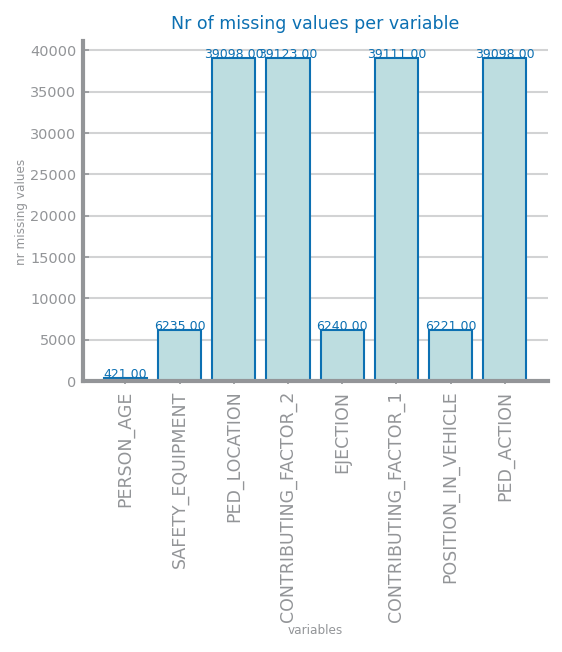

In [46]:
mv = {}
figure()
for var in df:
    nr = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr

bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable', xlabel='variables', ylabel='nr missing values', rotation=True)

savefig(DIMENSIONALITY_FOLDER + '/missing_values_before.png')

show()

### Drop column if missing values > 85%

In [47]:
threshold = df.shape[0] * 0.85

missings = [c for c in mv.keys() if mv[c] > threshold]
df = df.drop(columns=missings, inplace=False)

print('Dropped variables', missings)

Dropped variables ['PED_LOCATION', 'CONTRIBUTING_FACTOR_2', 'CONTRIBUTING_FACTOR_1', 'PED_ACTION']


### Drop records if missing values > 50%

In [48]:
threshold = df.shape[1] * 0.50
df = df.dropna(thresh=threshold, inplace=False)

print(df.shape)

(45669, 11)


### Show missing values after these changes

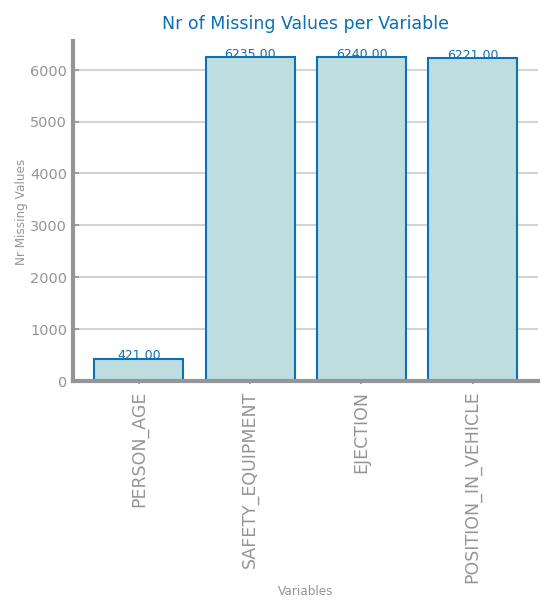

In [49]:
mv = {}
figure()
for var in df:
    nr = df[var].isna().sum()
    if nr > 0:
        mv[var] = nr
bar_chart(list(mv.keys()), list(mv.values()), title='Nr of Missing Values per Variable', xlabel='Variables', ylabel='Nr Missing Values', rotation=True)

savefig(DIMENSIONALITY_FOLDER + '/missing_values_after.png')

show()

### Impute other missing values

In [50]:
tmp_nr, tmp_sb, tmp_bool = None, None, None
variables = get_variable_types(df)
numeric_vars = variables['Numeric']
symbolic_vars = variables['Symbolic']
binary_vars = variables['Binary']

if len(numeric_vars) > 0:
    imp = SimpleImputer(strategy='mean', missing_values=nan, copy=True)
    tmp_nr = DataFrame(imp.fit_transform(df[numeric_vars]), columns=numeric_vars)
if len(symbolic_vars) > 0:
    imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
    tmp_sb = DataFrame(imp.fit_transform(df[symbolic_vars]), columns=symbolic_vars)
if len(binary_vars) > 0:
    imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
    tmp_bool = DataFrame(imp.fit_transform(df[binary_vars]), columns=binary_vars)

df = concat([tmp_nr, tmp_sb, tmp_bool], axis=1)

df.to_csv(f'{DATA_PREP_FOLDER}/drop_mv.csv', index=False)

df.describe(include='all')

,PERSON_AGE,BODILY_INJURY,SAFETY_EQUIPMENT,PERSON_SEX,PERSON_TYPE,EJECTION,COMPLAINT,POSITION_IN_VEHICLE,PED_ROLE,PERSON_INJURY
count,45669.000000,45669,45669,45669,45669,45669,45669,45669,45669,45669
unique,NaN,14,16,3,4,4,19,10,5,2
top,NaN,Back,Lap Belt & Harness,M,Occupant,Not Ejected,Complaint of Pain or Nausea,Driver,Driver,Injured
freq,NaN,7505,24419,27573,32903,42123,27958,32274,26542,45416
mean,37.487646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,81.115536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-971.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,34.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Remove outliers

In [51]:
df.loc[df['PERSON_AGE'] <= 0, 'PERSON_AGE'] = df['PERSON_AGE'].mean()
df.loc[df['PERSON_AGE'] > 100, 'PERSON_AGE'] = df['PERSON_AGE'].mean()

df

,PERSON_AGE,BODILY_INJURY,SAFETY_EQUIPMENT,PERSON_SEX,PERSON_TYPE,EJECTION,COMPLAINT,POSITION_IN_VEHICLE,PED_ROLE,PERSON_INJURY
0,37.0,Neck,Lap Belt & Harness,M,Occupant,Not Ejected,Complaint of Pain or Nausea,Driver,Driver,Injured
1,22.0,Shoulder - Upper Arm,Lap Belt & Harness,M,Occupant,Not Ejected,Complaint of Pain or Nausea,Driver,Driver,Injured
2,43.0,Elbow-Lower-Arm-Hand,Lap Belt & Harness,M,Pedestrian,Not Ejected,Minor Bleeding,Driver,Pedestrian,Injured
3,68.0,Neck,Lap Belt & Harness,F,Occupant,Not Ejected,Complaint of Pain or Nausea,"Front passenger, if two or more persons, inclu...",Passenger,Injured
4,22.0,Neck,Lap Belt & Harness,M,Occupant,Not Ejected,Complaint of Pain or Nausea,Driver,Driver,Injured
...,...,...,...,...,...,...,...,...,...,...
45664,28.0,Knee-Lower Leg Foot,Lap Belt,F,Occupant,Not Ejected,Unknown,Driver,Driver,Injured
45665,25.0,Head,Unknown,M,Other Motorized,Ejected,Concussion,"Middle rear seat, or passenger lying across a ...",Passenger,Injured
45666,30.0,Knee-Lower Leg Foot,Lap Belt & Harness,F,Occupant,Not Ejected,Internal,Driver,Driver,Injured
45667,62.0,Neck,Lap Belt & Harness,M,Occupant,Not Ejected,Complaint of Pain or Nausea,Driver,Driver,Injured


### Agreggate symbolic variables in groups

In [52]:
head_cat = ['Head', 'Face', 'Eye']
upper_body_cat = ['Neck', 'Shoulder - Upper Arm', 'Elbow-Lower-Arm-Hand', 'Back', 'Chest', 'Abdomen - Pelvis']
lower_body_cat = ['Hip-Upper Leg', 'Knee-Lower Leg Foot']
unknown_cat = ['Unknown', 'Does Not Apply', 'Entire Body']

df.replace(regex=head_cat, value='head', inplace=True)
df.replace(regex=upper_body_cat, value='upper_body', inplace=True)
df.replace(regex=lower_body_cat, value='lower_body', inplace=True)
df.replace(regex=unknown_cat, value='unknown', inplace=True)

df["BODILY_INJURY"]

0        upper_body
1        upper_body
2        upper_body
3        upper_body
4        upper_body
            ...    
45664    lower_body
45665          head
45666    lower_body
45667    upper_body
45668    lower_body
Name: BODILY_INJURY, Length: 45669, dtype: object

## **Dummification**

In [53]:
def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = DataFrame(trans_X, columns=new_vars, index=X.index)
    dummy = dummy.convert_dtypes(convert_boolean=True)
    
    final_df = concat([df[other_vars], dummy], axis=1)
    return final_df

# We choose just the symbolic variables that had at the most 5 different values
symbolic_vars = ['BODILY_INJURY', 'PERSON_SEX', 'PERSON_TYPE', 'EJECTION', 'PED_ROLE']

df = dummify(df, symbolic_vars)

print(df.info())
df.describe(include=[bool])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45669 entries, 0 to 45668
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PERSON_AGE                   45669 non-null  float64
 1   SAFETY_EQUIPMENT             45669 non-null  object 
 2   COMPLAINT                    45669 non-null  object 
 3   POSITION_IN_VEHICLE          45669 non-null  object 
 4   PERSON_INJURY                45669 non-null  object 
 5   BODILY_INJURY_head           45669 non-null  boolean
 6   BODILY_INJURY_lower_body     45669 non-null  boolean
 7   BODILY_INJURY_unknown        45669 non-null  boolean
 8   BODILY_INJURY_upper_body     45669 non-null  boolean
 9   PERSON_SEX_F                 45669 non-null  boolean
 10  PERSON_SEX_M                 45669 non-null  boolean
 11  PERSON_SEX_U                 45669 non-null  boolean
 12  PERSON_TYPE_Bicyclist        45669 non-null  boolean
 13  PERSON_TYPE_Occu

,BODILY_INJURY_head,BODILY_INJURY_lower_body,BODILY_INJURY_unknown,BODILY_INJURY_upper_body,PERSON_SEX_F,PERSON_SEX_M,PERSON_SEX_U,PERSON_TYPE_Bicyclist,PERSON_TYPE_Occupant,PERSON_TYPE_Other Motorized,PERSON_TYPE_Pedestrian,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,PED_ROLE_Driver,PED_ROLE_In-Line Skater,PED_ROLE_Other,PED_ROLE_Passenger,PED_ROLE_Pedestrian
count,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669,45669
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,True,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False
freq,37812,36790,40279,23543,27657,27573,45585,41205,32903,43782,39254,42977,42123,44913,45571,26542,45643,45539,33113,39254


#### Transforming remaining Symbolic vars in Numeric vars

In [67]:
symbolic_vars = get_variable_types(df)['Symbolic']
if symbolic_vars:
    label_encoder = LabelEncoder()
    for var in symbolic_vars:
        df[var] = label_encoder.fit_transform(df[var])
        
df.to_csv(DATA_PREP_FOLDER + "dummification.csv", index=False)

df

,PERSON_AGE,SAFETY_EQUIPMENT,COMPLAINT,POSITION_IN_VEHICLE,PERSON_INJURY,BODILY_INJURY_head,BODILY_INJURY_lower_body,BODILY_INJURY_unknown,BODILY_INJURY_upper_body,PERSON_SEX_F,...,PERSON_TYPE_Pedestrian,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,PED_ROLE_Driver,PED_ROLE_In-Line Skater,PED_ROLE_Other,PED_ROLE_Passenger,PED_ROLE_Pedestrian
0,0.363636,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
1,0.212121,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
2,0.424242,0.666667,0.470588,0.111111,Injured,False,False,False,True,False,...,True,False,True,False,False,False,False,False,False,True
3,0.676768,0.666667,0.117647,0.222222,Injured,False,False,False,True,True,...,False,False,True,False,False,False,False,False,True,False
4,0.212121,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45664,0.272727,0.600000,1.000000,0.111111,Injured,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,False
45665,0.242424,1.000000,0.176471,0.666667,Injured,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
45666,0.292929,0.666667,0.411765,0.111111,Injured,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,False
45667,0.616162,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False


## **Scaling**

### Standard Scaler

In [55]:
variable_types = get_variable_types(df)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = df[numeric_vars]
df_sb = df[symbolic_vars]
df_bool = df[boolean_vars]

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=df.index, columns= numeric_vars)
norm_data_zscore = concat([tmp, df_sb,  df_bool], axis=1)

norm_data_zscore.to_csv(f'{DATA_PREP_FOLDER}/scaled_z_score.csv', index=False)

norm_data_zscore

,PERSON_AGE,SAFETY_EQUIPMENT,COMPLAINT,POSITION_IN_VEHICLE,PERSON_INJURY,BODILY_INJURY_head,BODILY_INJURY_lower_body,BODILY_INJURY_unknown,BODILY_INJURY_upper_body,PERSON_SEX_F,...,PERSON_TYPE_Pedestrian,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,PED_ROLE_Driver,PED_ROLE_In-Line Skater,PED_ROLE_Other,PED_ROLE_Passenger,PED_ROLE_Pedestrian
0,0.011182,-0.120052,-0.591313,-0.470230,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
1,-0.901108,-0.120052,-0.591313,-0.470230,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
2,0.376098,-0.120052,0.684659,-0.470230,Injured,False,False,False,True,False,...,True,False,True,False,False,False,False,False,False,True
3,1.896582,-0.120052,-0.591313,0.004281,Injured,False,False,False,True,True,...,False,False,True,False,False,False,False,False,True,False
4,-0.901108,-0.120052,-0.591313,-0.470230,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45664,-0.536192,-0.503963,2.598616,-0.470230,Injured,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,False
45665,-0.718650,1.799507,-0.378651,1.902326,Injured,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
45666,-0.414553,-0.120052,0.471997,-0.470230,Injured,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,False
45667,1.531666,-0.120052,-0.591313,-0.470230,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False


### MinMax Scaler

In [56]:
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=df.index, columns= numeric_vars)
norm_data_minmax = concat([tmp, df_sb,  df_bool], axis=1)

norm_data_minmax.to_csv(f'{DATA_PREP_FOLDER}/scaled_minmax.csv', index=False)

print(norm_data_minmax.describe())

          PERSON_AGE  SAFETY_EQUIPMENT     COMPLAINT  POSITION_IN_VEHICLE  \
count   45669.000000      45669.000000  45669.000000         45669.000000   
unique           NaN               NaN           NaN                  NaN   
top              NaN               NaN           NaN                  NaN   
freq             NaN               NaN           NaN                  NaN   
mean        0.361779          0.687514      0.281208             0.221220   
std         0.166084          0.173653      0.276609             0.234162   
min         0.000000          0.000000      0.000000             0.000000   
25%         0.242424          0.666667      0.117647             0.111111   
50%         0.333333          0.666667      0.117647             0.111111   
75%         0.474747          0.733333      0.470588             0.222222   
max         1.000000          1.000000      1.000000             1.000000   

       BODILY_INJURY_head BODILY_INJURY_lower_body BODILY_INJURY_unknown  \

### Scaling Comparison

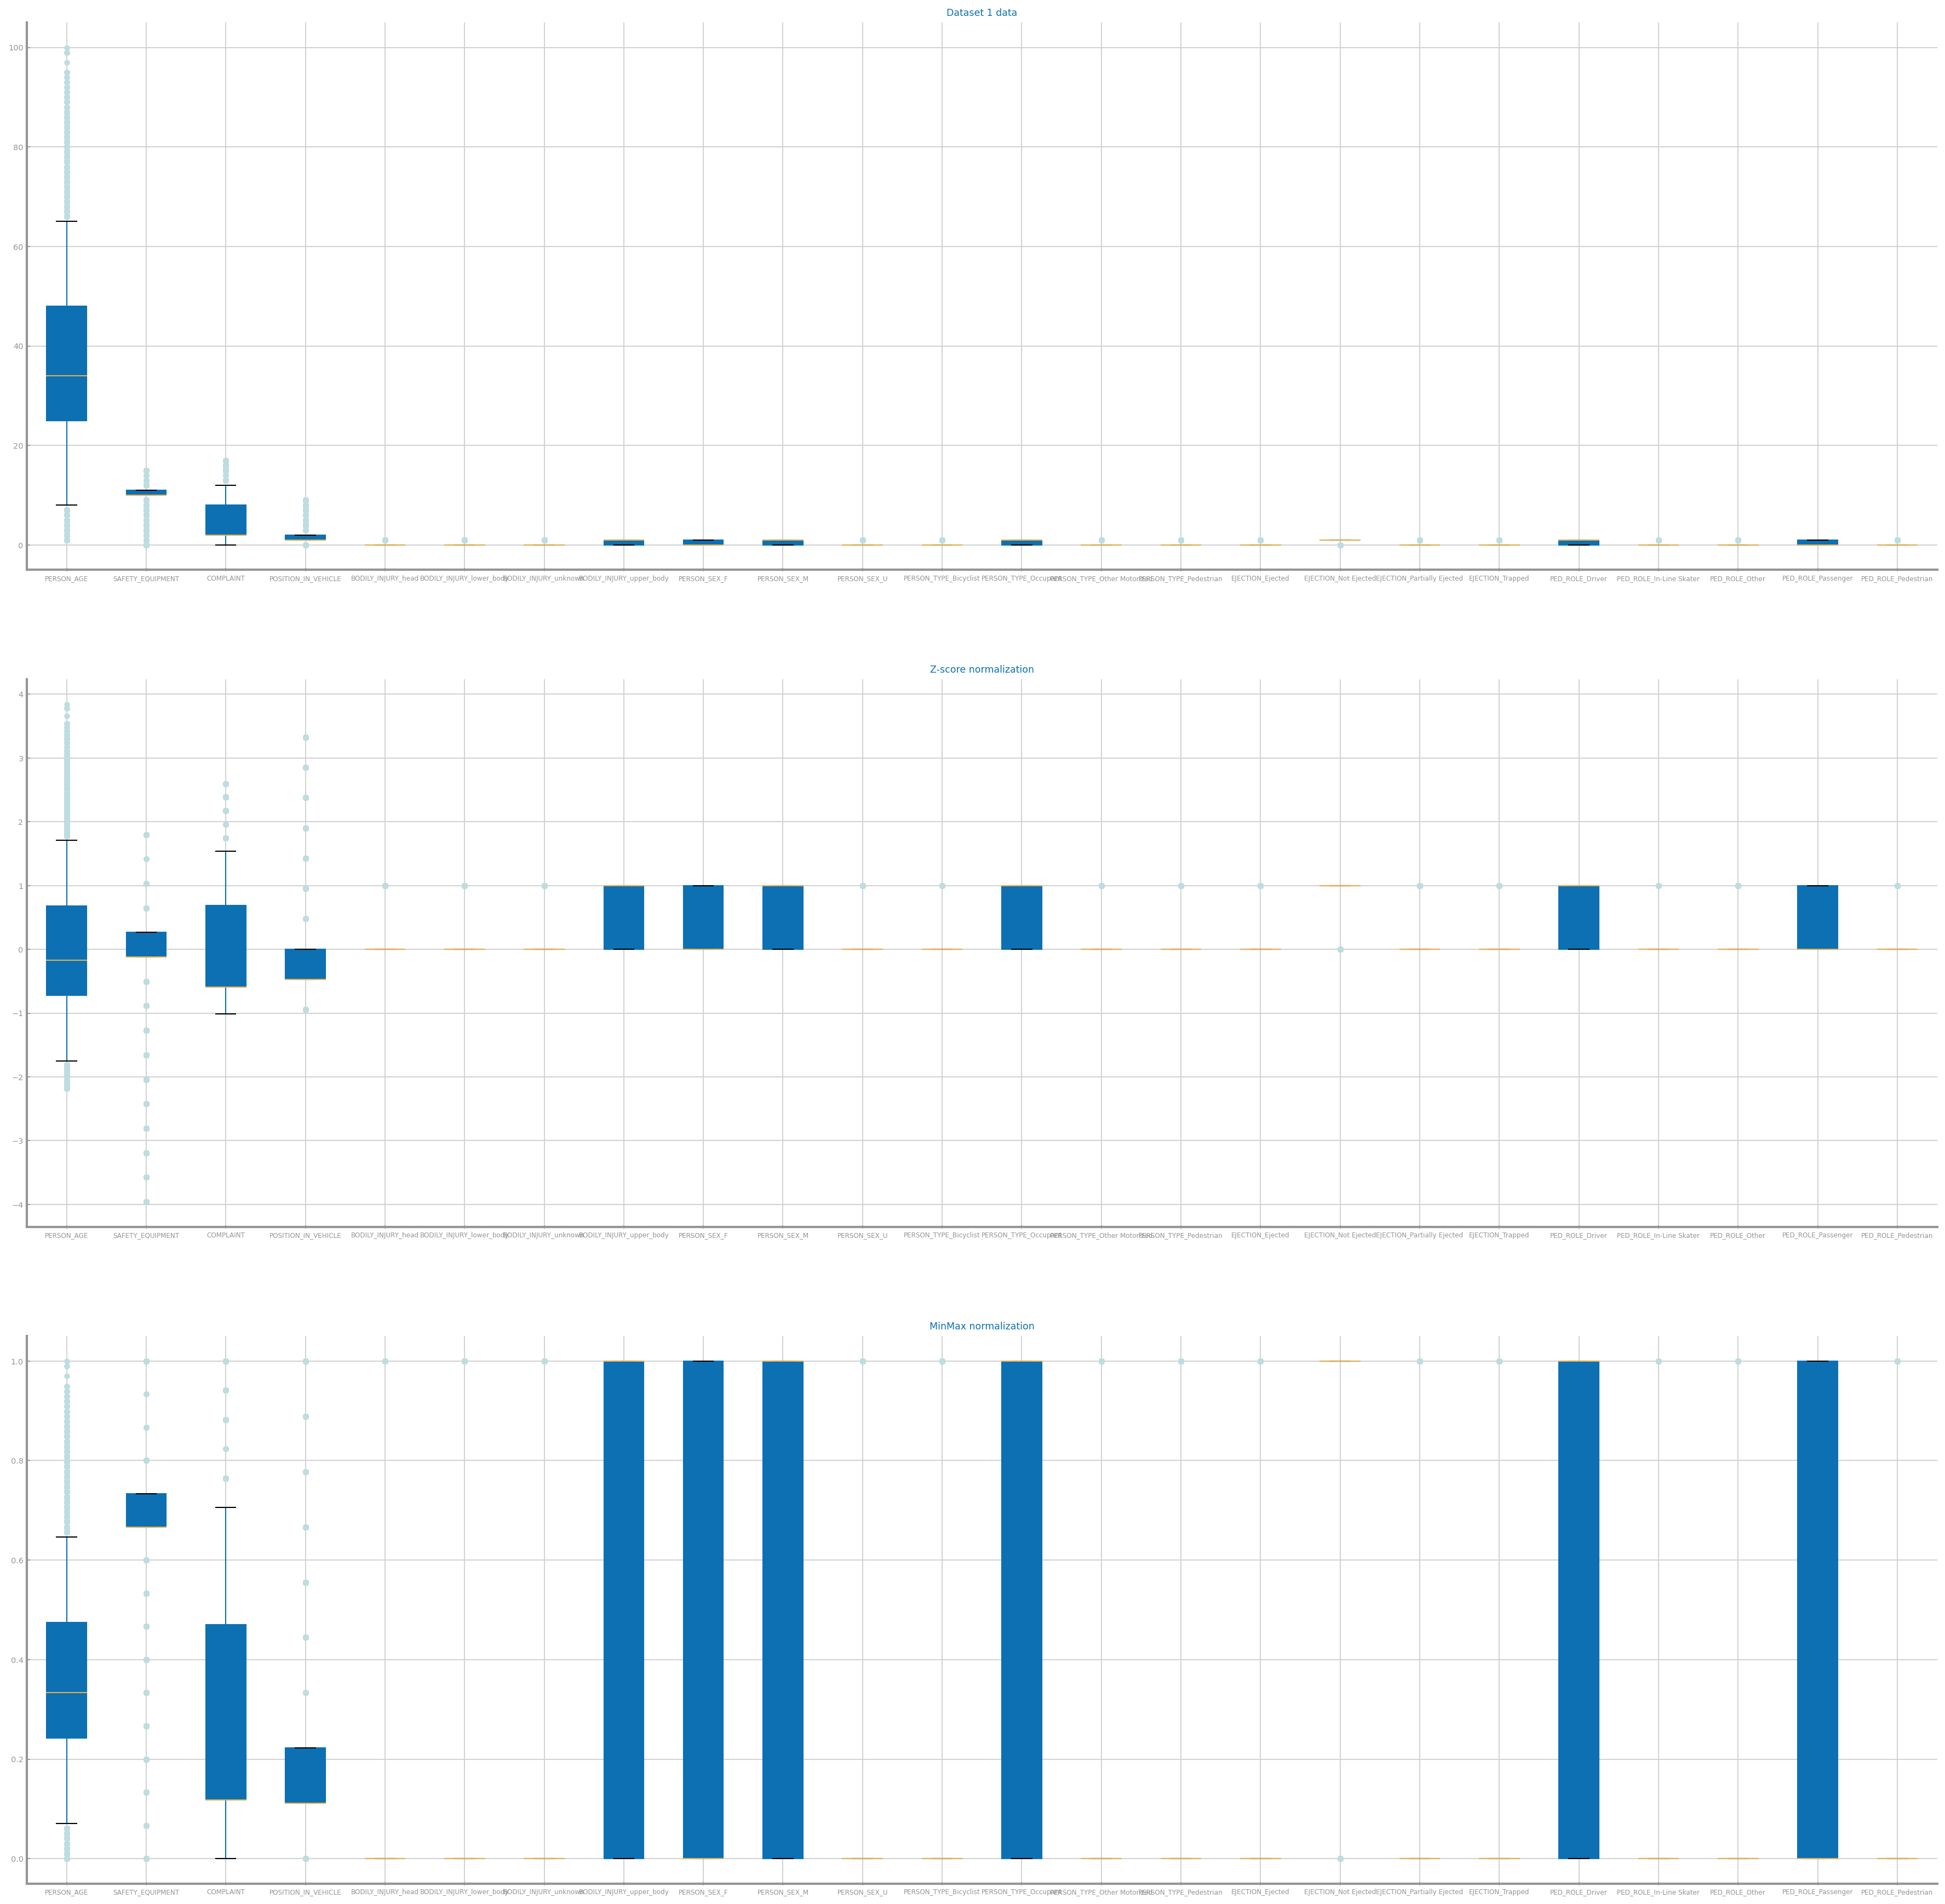

In [57]:
fig, axs = subplots(3, 1, figsize=(30,30),squeeze=False)

axs[0, 0].set_title('Dataset 1 data')
df.boxplot(ax=axs[0, 0])

axs[1, 0].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[1, 0])

axs[2, 0].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[2, 0])

savefig(SCALING_FOLDER + '/normalization.png')

show()

Based on the image above, we can observe that the Z-score and MinMax normalizations produce very similar results, so we can choose arbitrarily one of them. 

We decided to pick the MinMax normalization

In [58]:
df = norm_data_minmax
df

,PERSON_AGE,SAFETY_EQUIPMENT,COMPLAINT,POSITION_IN_VEHICLE,PERSON_INJURY,BODILY_INJURY_head,BODILY_INJURY_lower_body,BODILY_INJURY_unknown,BODILY_INJURY_upper_body,PERSON_SEX_F,...,PERSON_TYPE_Pedestrian,EJECTION_Ejected,EJECTION_Not Ejected,EJECTION_Partially Ejected,EJECTION_Trapped,PED_ROLE_Driver,PED_ROLE_In-Line Skater,PED_ROLE_Other,PED_ROLE_Passenger,PED_ROLE_Pedestrian
0,0.363636,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
1,0.212121,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
2,0.424242,0.666667,0.470588,0.111111,Injured,False,False,False,True,False,...,True,False,True,False,False,False,False,False,False,True
3,0.676768,0.666667,0.117647,0.222222,Injured,False,False,False,True,True,...,False,False,True,False,False,False,False,False,True,False
4,0.212121,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45664,0.272727,0.600000,1.000000,0.111111,Injured,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,False
45665,0.242424,1.000000,0.176471,0.666667,Injured,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
45666,0.292929,0.666667,0.411765,0.111111,Injured,False,True,False,False,True,...,False,False,True,False,False,True,False,False,False,False
45667,0.616162,0.666667,0.117647,0.111111,Injured,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False


## **Data Balancing**

Minority (Positive) class= Killed : 253
Majority (Negative) class= Injured : 45416
Proportion: 0.01 : 1


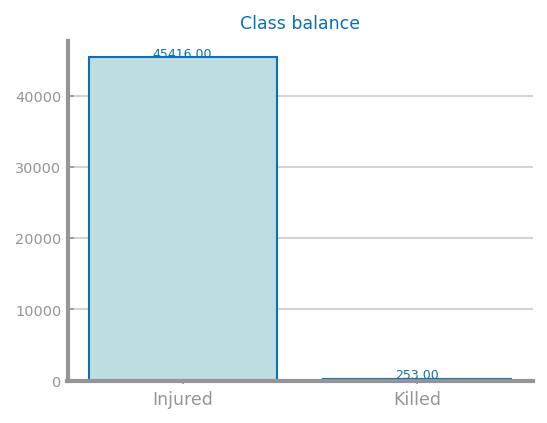

In [59]:
class_var = 'PERSON_INJURY'

target_count = df[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority (Positive) class=', positive_class, ':', target_count[positive_class])
print('Majority (Negative) class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'df': [target_count[positive_class], target_count[negative_class]]}

figure()
bar_chart(target_count.index, target_count.values, title='Class balance')

savefig(f'{BALANCING_FOLDER}/unbalanced_balance.png')

show()

In [60]:
df_positives = df[df[class_var] == positive_class]
df_negatives = df[df[class_var] == negative_class]

df_neg_sample = DataFrame(df_negatives.sample(len(df_positives)))
df_under = concat([df_positives, df_neg_sample], axis=0)

#df_under.to_csv(f'{DATA_PREP_FOLDER}/balance_under.csv', index=False)

values['UnderSample'] = [len(df_positives), len(df_neg_sample)]

print('Minority class=', positive_class, ':', len(df_positives))
print('Majority class=', negative_class, ':', len(df_neg_sample))
print('Proportion:', round(len(df_positives) / len(df_neg_sample), 2), ': 1')

Minority class= Killed : 253
Majority class= Injured : 253
Proportion: 1.0 : 1


In [61]:
df_pos_sample = DataFrame(df_positives.sample(len(df_negatives), replace=True))
df_over = concat([df_pos_sample, df_negatives], axis=0)

#df_under.to_csv(f'{DATA_PREP_FOLDER}/balance_over.csv', index=False)

values['OverSample'] = [len(df_pos_sample), len(df_negatives)]

print('Minority class=', positive_class, ':', len(df_pos_sample))
print('Majority class=', negative_class, ':', len(df_negatives))
print('Proportion:', round(len(df_pos_sample) / len(df_negatives), 2), ': 1')

Minority class= Killed : 45416
Majority class= Injured : 45416
Proportion: 1.0 : 1


#### SMOTE balancing

In [62]:
RANDOM_STATE = 42

df_copy = df.copy(deep=True)

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)


y = df_copy.pop(class_var).values
X = df_copy.values

smote_X, smote_y = smote.fit_resample(X, y)
df_smote = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)

df_smote.columns = list(df_copy.columns) + [class_var]

#df_smote.to_csv(f'{DATA_PREP_FOLDER}/balance_smote.csv', index=False)

smote_target_count = Series(smote_y).value_counts()

values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]

print('Minority class=', positive_class, ':', smote_target_count[positive_class])
print('Majority class=', negative_class, ':', smote_target_count[negative_class])
print('Proportion:', round(smote_target_count[positive_class] / smote_target_count[negative_class], 2), ': 1')

Minority class= Killed : 45416
Majority class= Injured : 45416
Proportion: 1.0 : 1


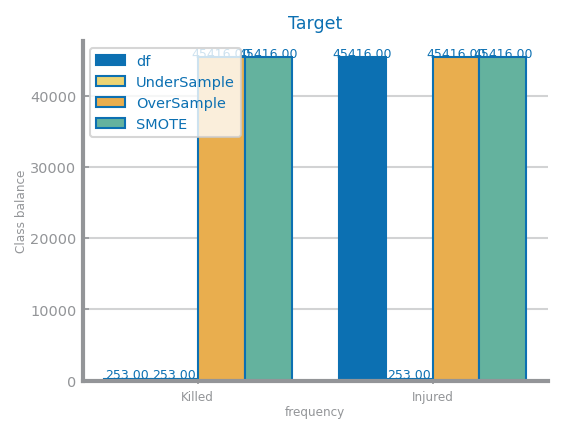

In [63]:
figure()
multiple_bar_chart([positive_class, negative_class], values, title='Target', xlabel='frequency', ylabel='Class balance')

savefig(f'{BALANCING_FOLDER}/balancing_strategies_comparison.png')

show()

## **Save the prepared dataset**

In [64]:
df.to_csv(DATA_FOLDER + "data_prep_final.csv", index=False)